# GUILHERME LOURENÇO: 

### <span style="color:blue">MBA em Ciência de Dados</span>
### <span style="color:blue">Redes Neurais e Arquiteturas Profundas</span>
### <span style="color:blue">Análise de Dados com Base em Processamento Massivo em Paralelo</span>

### <span style="color:blue">Prova Final</span>

**Material Produzido por:**<br>
>**Profa. Dra. Cristina Dutra de Aguiar Ciferri**<br>
>**Prof. Dr. Moacir A. Ponti**<br> 

**CEMEAI - ICMC/USP São Carlos**


*A prova final contém 1 questão, dividida em 4 itens. Por favor, procurem por Questão para encontrar a especificação da questão e por Item para encontrar a especificação do item. Também é possível localizar a questão e os itens utilizando o menu de navegação. O notebook contém a constelação de fatos da BI Solutions que deve ser utilizada para responder à questão e também todas as `bibliotecas`, `bases de dados`, `inicializações`, `instalações`, `importações`, `geração de dataFrames`, `geração de visões temporárias` e `conversão dos tipos de dados` necessárias para a realização da questão.*


**INSTRUÇÕES**:<br>
1) Você deve exportar esse notebook com sua solução para as questões da prova em formato .py e fazer upload no Moodle. Atenção: você não deve fazer upload de um arquivo notebook (.ipynb), mas sim um arquivo texto .py contendo os códigos python que utilizou para resolver as questões. O arquivo .py pode ser gerado através da opção:<br>
File --> Download as --> Python (.py)
disponível no Jupyter Notebook.

ou
File --> Download .py
no Google Colab

Caso não esteja utilizando o Jupyter, copie e cole seu código em um arquivo ASCII (Texto) salvando com a extensão .py

2) Você deve salvar esse notebook com sua solução para as questões da prova em formato .pdf e fazer upload no Moodle

3) Os arquivos devem ser nomeados com seu nome e sobrenome, sem espaços. Exemplo: moacirponti.py e moacirponti.pdf

4) É OBRIGATÓRIO conter no cabeçalho (início) do arquivo um comentário / texto com o seu nome completo


**Desejamos uma boa prova!**

#1 Constelação de Fatos da BI Solutions

A aplicação de *data warehousing* da BI Solutions utiliza como base uma contelação de fatos, conforme descrita a seguir.

**Tabelas de dimensão**

- data (dataPK, dataCompleta, dataDia, dataMes, dataBimestre, dataTrimestre, dataSemestre, dataAno)
- funcionario (funcPK, funcMatricula, funcNome, funcSexo, funcDataNascimento, funcDiaNascimento, funcMesNascimento, funcAnoNascimento, funcCidade, funcEstadoNome, funcEstadoSigla, funcRegiaoNome, funcRegiaoSigla, funcPaisNome, funcPaisSigla)
- equipe (equipePK, equipeNome, filialNome, filialCidade, filialEstadoNome, filialEstadoSigla, filialRegiaoNome, filialRegiaoSigla, filialPaisNome, filialPaisSigla)
- cargo (cargoPK, cargoNome, cargoRegimeTrabalho, cargoEscolaridadeMinima, cargoNivel)
- cliente (clientePK, clienteNomeFantasia, clienteSetor, clienteCidade, clienteEstadoNome, clienteEstadoSigla, clienteRegiaoNome, clienteRegiaoSigla, clientePaisNome, clientePaisSigla)

**Tabelas de fatos**
- pagamento (dataPK, funcPK, equipePK, cargoPK, salario, quantidadeLancamentos)
- negociacao (dataPK, equipePK, clientePK, receita, quantidadeNegociacoes)


#2 Configurações 


## 2.1 Obtenção dos Dados da BI Solutions

In [1]:
#instalando o módulo wget
# %%capture
# !pip install -q wget
!mkdir data

#baixando os dados das tabelas de dimensão e das tabelas de fatos
import wget

url = "https://raw.githubusercontent.com/cdaciferri/DataMartBISolutions/main/data.csv"
wget.download(url, "data/data.csv")

url = "https://raw.githubusercontent.com/cdaciferri/DataMartBISolutions/main/funcionario.csv"
wget.download(url, "data/funcionario.csv")

url = "https://raw.githubusercontent.com/cdaciferri/DataMartBISolutions/main/equipe.csv"
wget.download(url, "data/equipe.csv")

url = "https://raw.githubusercontent.com/cdaciferri/DataMartBISolutions/main/cargo.csv"
wget.download(url, "data/cargo.csv")

url = "https://raw.githubusercontent.com/cdaciferri/DataMartBISolutions/main/cliente.csv"
wget.download(url, "data/cliente.csv")

url = "https://raw.githubusercontent.com/cdaciferri/DataMartBISolutions/main/pagamento.csv"
wget.download(url, "data/pagamento.csv")

url = "https://raw.githubusercontent.com/cdaciferri/DataMartBISolutions/main/negociacao.csv"
wget.download(url, "data/negociacao.csv")

'data/negociacao.csv'

## 2.2 Instalações e Inicializações

In [2]:
#instalando Java Runtime Environment (JRE) versão 8
# %%capture
# !apt-get remove openjdk*
# !apt-get update --fix-missing
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
#baixando Apache Spark versão 3.0.0
# %%capture
# !wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
# !tar xf spark-3.0.0-bin-hadoop2.7.tgz && rm spark-3.0.0-bin-hadoop2.7.tgz

In [2]:
import os
#configurando a variável de ambiente JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#configurando a variável de ambiente SPARK_HOME
os.environ["SPARK_HOME"] = "./spark-3.0.0-bin-hadoop2.7"

In [5]:
# %%capture
#instalando o pacote findspark
# !pip install -q findspark==1.4.2
#instalando o pacote pyspark
# !pip install -q pyspark==3.0.0

## 2.3 Bibliotecas

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark-notebook").master("local[*]").getOrCreate()

from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import round, desc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

## 2.4 Geração dos DataFrames em Spark da BI Solutions


In [4]:
#criando os DataFrames em Spark 
cargo = spark.read.csv(path="data/cargo.csv", header=True, sep=",")
cliente = spark.read.csv(path="data/cliente.csv", header=True, sep=",")
data = spark.read.csv(path="data/data.csv", header=True, sep=",")
equipe = spark.read.csv(path="data/equipe.csv", header=True, sep=",")
funcionario = spark.read.csv(path="data/funcionario.csv", header=True, sep=",")
negociacao = spark.read.csv(path="data/negociacao.csv", header=True, sep=",")
pagamento = spark.read.csv(path="data/pagamento.csv", header=True, sep=",")

In [5]:
#convertendo os dados necessários para o tipo de dado inteiro
colunas_cargo = ["cargoPK"]
colunas_cliente = ["clientePK"]
colunas_data = ["dataPk", "dataDia", "dataMes", "dataBimestre", "dataTrimestre", "dataSemestre", "dataAno"]
colunas_equipe = ["equipePK"]
colunas_funcionario = ["funcPK", "funcDiaNascimento", "funcMesNascimento", "funcAnoNascimento"]
colunas_negociacao = ["equipePK", "clientePK", "dataPK", "quantidadeNegociacoes"]
colunas_pagamento = ["funcPK", "equipePK", "dataPK", "cargoPK", "quantidadeLancamentos"]

for coluna in colunas_cargo:
  cargo = cargo.withColumn(coluna, cargo[coluna].cast(IntegerType()))

for coluna in colunas_cliente:
  cliente = cliente.withColumn(coluna, cliente[coluna].cast(IntegerType()))

for coluna in colunas_data:
  data = data.withColumn(coluna, data[coluna].cast(IntegerType()))

for coluna in colunas_equipe:
  equipe = equipe.withColumn(coluna, equipe[coluna].cast(IntegerType()))

for coluna in colunas_funcionario:
  funcionario = funcionario.withColumn(coluna, funcionario[coluna].cast(IntegerType()))

for coluna in colunas_negociacao:
  negociacao = negociacao.withColumn(coluna, negociacao[coluna].cast(IntegerType()))

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(IntegerType()))

In [6]:
#convertendo os dados necessários para o tipo de dado float
colunas_negociacao = ["receita"]
colunas_pagamento = ["salario"]

for coluna in colunas_negociacao:
  negociacao = negociacao.withColumn(coluna, negociacao[coluna].cast(FloatType()))

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(FloatType()))

In [7]:
#criando as visões temporárias 
cargo.createOrReplaceTempView("cargo")
cliente.createOrReplaceTempView("cliente")
data.createOrReplaceTempView("data")
equipe.createOrReplaceTempView("equipe")
funcionario.createOrReplaceTempView("funcionario")
negociacao.createOrReplaceTempView("negociacao")
pagamento.createOrReplaceTempView("pagamento")

# 3 Questão

A empresa BI Solutions resolveu realizar uma sindicância nos salários dos funcionários do ano de 2017. O objetivo da sindicância é identificar funcionários cujo padrão de recebimento de salário em 2017 esteja fora do padrão dos salários pagos em 2016, considerando que os dados de 2016 já foram auditados e estão adequados.

Para tanto, a empresa resolveu utilizar uma rede neural para identificar *anomalias* e, a partir dessas *anomalias*, investigar os funcionários.

**IMPORTANTE**: Leia a questão com muita atenção, desde que vários passos da questão já se encontram implementados. Os locais nos quais os comandos da questão devem ser especificados são identificados em comentários. 

### 3.1 Dados para o Modelo

#### 3.1.1 Consulta dataAno 2016

*Esta parte da questão já está resolvida. Realize a leitura do enunciado e da resposta.*

Considere a consulta a seguir, a qual retorna os valores dos atributos `funcPK`, `equipePK`, `dataPK`, `cargoPK` e `salario` da relação `pagamento`, considerando os pagamentos realizados na `dataAno` de `2016`. 
**A resposta desta consulta deve ser usada para treinar o modelo posteriormente. Note que essa resposta é armazenada no dataFrame `respostaPandas16`, que é um dataFrame em Pandas.**

In [8]:
#especificando a consulta que retorna os valores dos atributos
#funcPK, equipePK, dataPK, cargoPK e salario
#para pagamentos realizados na dataAno de 2016
query2016 = query = """
SELECT funcPK, equipePK, pagamento.dataPK, cargoPK, salario
FROM pagamento, data
WHERE pagamento.dataPK = data.dataPK
      AND dataAno = 2016
ORDER BY funcPK, equipePK, pagamento.dataPK, cargoPK, salario       
"""

#transformando o resultado em um dataFrame em Pandas
respostaPandas16 = spark.sql(query2016).toPandas()

#exibindo algumas linhas do dataFrame respostaPandas16
respostaPandas16

,funcPK,equipePK,dataPK,cargoPK,salario
0,5,2,5,112,2226.659912
1,5,2,36,112,2226.659912
2,5,2,65,112,2226.659912
3,5,2,96,112,2226.659912
4,5,2,126,112,2226.659912
...,...,...,...,...,...
595,199,2,218,116,4703.600098
596,199,2,249,116,4703.600098
597,199,2,279,116,4703.600098
598,199,2,310,116,4703.600098


#### 3.1.2 Consulta dataAno 2017

*Esta parte da questão já está resolvida. Realize a leitura do enunciado e da resposta.*

Considere a consulta a seguir, a qual retorna os valores dos atributos `funcPK`, `equipePK`, `dataPK`, `cargoPK` e `salario` da relação `pagamento`, considerando os pagamentos realizados na `dataAno` de `2017`. 
**A resposta desta consulta deve ser verificada posteriormente utilizando a rede neural já treinada (mais detalhes abaixo). Note que essa resposta é armazenada no dataFrame `respostaPandas17`, que é um dataFrame em Pandas.**

In [9]:
#especificando a consulta que retorna os valores dos atributos
#funcPK, equipePK, dataPK, cargoPK e salario
#para pagamentos realizados na dataAno de 2017
query2017 = query = """
SELECT funcPK, equipePK, pagamento.dataPK, cargoPK, salario
FROM pagamento, data
WHERE pagamento.dataPK = data.dataPK
      AND dataAno = 2017
ORDER BY funcPK desc, equipePK, pagamento.dataPK, cargoPK, salario       
"""

#transformando o resultado em um dataFrame em Pandas
respostaPandas17 = spark.sql(query2017).toPandas()

#exibindo algumas linhas do dataFrame respostaPandas17
respostaPandas17

,funcPK,equipePK,dataPK,cargoPK,salario
0,200,5,371,318,10631.740234
1,200,5,402,318,10631.740234
2,200,5,430,318,10631.740234
3,200,5,461,318,10631.740234
4,200,5,491,318,10631.740234
...,...,...,...,...,...
1315,2,3,583,463,1668.939941
1316,2,3,614,463,1668.939941
1317,2,3,644,463,1668.939941
1318,2,3,675,463,1668.939941


### 3.2 Especificação da Rede Neural

#### 3.2.1 Conversão dos dataFrames

*Esta parte da questão já está resolvida. Realize a leitura do enunciado e da resposta.*

Execute os comandos a seguir, os quais convertem os `dataFrames` `respostaPandas16` e `respostaPandas17` para `numpy array`.

In [10]:
#Convertendo os dataFrames para numpy array
x_train = respostaPandas16.to_numpy(copy=False)
x_test = respostaPandas17.to_numpy(copy=False)

#### 3.2.2 Inicialização das Sementes

*Esta parte da questão já está resolvida. Realize a leitura do enunciado e da resposta.*

Execute os comandos a seguir, os quais inicializam as sementes a serem utilizadas. 

In [11]:
#inicializando as sementes
seed(1)
set_seed(1)

#### 3.2.3 Normalização

*Esta parte da questão já está resolvida. Realize a leitura do enunciado e da resposta.*

Execute os comandos a seguir, nos quais atributos de entrada são normalizados por `min-max` para o intervalo `[0-1]`

In [12]:
#Normalizando min-max para 0-1 (usando max e min do treinamento)
max = x_train.max(axis=0)
min = x_train.min(axis=0)
x_train = (x_train-min)/(max-min)
print(x_train.shape)

x_test = (x_test-min)/(max-min)
print(x_test.shape)

(600, 5)
(1320, 5)


#### 3.2.4 Item 1 (RESOLVER)

Projete um **autoencoder** com a seguinte arquitetura, sendo todas as camadas com função de ativação `relu`:
  * Camada de entrada com 5 valores
  * Camada densa com 4 neurônios
  * Camada densa com 3 neurônios
  * Dropout com taxa= 1/3.0
  * Camada densa com 4 neurônios
  * Camada de saída

O objetivo desse autoencoder consiste em aprender uma representação para os dados do ano de 2016.

In [13]:
#Escreva aqui a sua resposta para o Item 1

input_data = keras.layers.Input(shape=5)
network = keras.layers.Dense(4, activation='relu')(input_data)
network = keras.layers.Dense(3, activation='relu')(network)
network = keras.layers.Dropout(1/3.0)(network)
network = keras.layers.Dense(4, activation='relu')(network)
output = keras.layers.Dense(5, activation='relu')(network)

model_2016 = keras.models.Model(input_data, output)
model_2016.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 25        
Total params: 80
Trainable params: 80
Non-trainable params: 0
__________________________________________________________

#### 3.2.5 Item 2 (RESOLVER)

**Compile** o modelo e **treine** por 250 épocas com batch_size 16, utilizando Adam com taxa de aprendizado inicial 0.002 e decaimento exponencial de -0.005 conforme funcão pré-definida abaixo.

In [14]:
# Função que define decaimento para a taxa de aprendizado 
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.005)

In [15]:
callback = keras.callbacks.LearningRateScheduler(scheduler)


In [16]:
#Escreva aqui a sua resposta para o Item 2
epochs = 250
batch_size = 16
noise_factor = 0.2

x_train_noised = x_train + noise_factor * np.random.normal(0, 1, x_train.shape)

model_2016.compile(
            loss = 'mse',
            optimizer = keras.optimizers.Adam(lr = 0.002)
            )



In [18]:
hist_2016 = model_2016.fit(
        x = x_train_noised,
        y = x_train,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = [callback],
        verbose = 2
        )

Epoch 1/250
38/38 - 0s - loss: 0.1526
Epoch 2/250
38/38 - 0s - loss: 0.1529
Epoch 3/250
38/38 - 0s - loss: 0.1510
Epoch 4/250
38/38 - 0s - loss: 0.1498
Epoch 5/250
38/38 - 0s - loss: 0.1522
Epoch 6/250
38/38 - 0s - loss: 0.1516
Epoch 7/250
38/38 - 0s - loss: 0.1511
Epoch 8/250
38/38 - 0s - loss: 0.1501
Epoch 9/250
38/38 - 0s - loss: 0.1516
Epoch 10/250
38/38 - 0s - loss: 0.1510
Epoch 11/250
38/38 - 0s - loss: 0.1517
Epoch 12/250
38/38 - 0s - loss: 0.1500
Epoch 13/250
38/38 - 0s - loss: 0.1513
Epoch 14/250
38/38 - 0s - loss: 0.1511
Epoch 15/250
38/38 - 0s - loss: 0.1495
Epoch 16/250
38/38 - 0s - loss: 0.1517
Epoch 17/250
38/38 - 0s - loss: 0.1502
Epoch 18/250
38/38 - 0s - loss: 0.1505
Epoch 19/250
38/38 - 0s - loss: 0.1516
Epoch 20/250
38/38 - 0s - loss: 0.1510
Epoch 21/250
38/38 - 0s - loss: 0.1508
Epoch 22/250
38/38 - 0s - loss: 0.1499
Epoch 23/250
38/38 - 0s - loss: 0.1504
Epoch 24/250
38/38 - 0s - loss: 0.1500
Epoch 25/250
38/38 - 0s - loss: 0.1488
Epoch 26/250
38/38 - 0s - loss: 0.

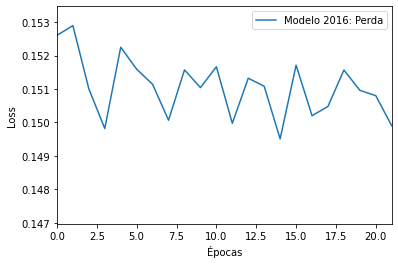

In [21]:
plt.plot(hist_2016.history['loss'])
plt.xlim(0, 21)
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.legend(['Modelo 2016: Perda'])
plt.show();

#### 3.2.6 Item 3 (RESOLVER)

Utilizando o conjunto de teste (`x_test`) como entrada para o modelo treinado, obtenha as saídas da predição usando `modelo.predict(x_test)`.  A seguir, compute a soma do erro quadrático, i.e. $||x - \hat{x}||^2$, sendo $x$ os atributos de entrada e $\hat{x}$ os valores de saída da rede neural, ou seja, o erro de reconstrução de cada exemplo de teste (original) com relação ao predito pelo modelo (exemplos resultados da saída da predição).

Armazene o erro de cada elemento organizados, em ordem, num array `error`.

O objetivo é verificar se alguma tupla do ano de 2017 possui alto erro de reconstrução, o que indicaria uma possível anomalia a ser investigada com relação aos atributos (cargo, equipe, salário, etc.).

In [19]:
#Escreva aqui a sua resposta para o Item 3
result = model_2016.predict(x_test)

In [27]:
from statsmodels.tools.eval_measures import rmse

error = rmse(x_test, result)
error

array([0.20210997, 2.32769882, 0.63233352, 0.19835846, 0.34277373])

#### 3.2.7 Obtendo o Valor de funcPK Relativo ao Maior Erro

*Esta parte da questão já está resolvida. Realize a leitura do enunciado e da resposta.*

Obtenha o valor do atributo `funcPK` não normalizado, referente ao `dataFrame` original, relativo à instância que possui o maior erro no teste. **O valor de `funcPK` deve ser usado para a especificação da consulta OLAP definida na seção 6.2.8.**

In [28]:
# Obtendo o valor de funcPK desejado 

k_maiores = 1 # obtem os k valores com maior erro
for i in np.argpartition(error,-k_maiores)[-k_maiores:]:
    print(respostaPandas17.iloc[i,0])

200


## 3.3 Investigação do Funcionário

Uma vez identificado o código do funcionário, observou-se que ele recebeu salário muito superior quando comparado com os salários dos demais funcionários da empresa. Esse funcionário deve ser investigado considerando, portanto, seu salário. Essa investigação deve ser feita por meio da especificação de consultas OLAP. 

Observações importantes:
- A **consulta OLAP** pode ser especificada:
   - Usando a **linguagem SQL** (conceitos apresentados na Aula 07)  
   OU (escolha somente uma forma)
   - Usando os métodos de **pyspark.sql** (conceitos apresentados na Aula 08). 
- Na listagem das respostas:
   - As **colunas** solicitadas devem ser exibidas exatamente na mesma ordem que a definida.
   - As **linhas** retornadas como respostas devem ser exibidas exatamente na mesma ordem que a definida. 
   - Os **nomes das colunas** renomeadas devem seguir estritamente os nomes definidos.
- Quando a consulta OLAP for especificada usando a **linguagem SQL**, use:
  - O comando `spark.sql(consultaSQL).show(20,truncate=False)` para exibir o resultado da consulta. Esse comando deve ser o último comando a ser especificado.
  - A função `ROUND(funçãoDeAgregação,2)` para arredondar o dado até duas casas decimais.
- Quando a consulta OLAP for especificada usando os demais **métodos de pyspark.sql**, use:
  - O comando `nomeDoDataFrame.show(20,truncate=False)` para exibir o resultado da consulta. Esse comando deve ser o último comando a ser especificado.
  - O método `round(funçãoDeAgregação,2)` para arredondar o dado até duas casas decimais. 

#### 3.3.1 Item 4 (RESOLVER)

**Faça uma consulta que tem como objetivo investigar os meses e os valores dos salários recebidos no ano de 2017 pelo funcionário que está sendo inspecionado.** Ou seja, liste para cada mês do ano de 2017, o nome do funcionário, o mês e o salário recebido pelo funcionário cujo valor de `funcPK` foi identificado logo após o Item 3. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "NOMEFUNCIONARIO", "MES" e "SALARIO". Arredonde os salários para até duas casas decimais. Ordene as linhas exibidas primeiro por salário em ordem **descendente** e depois por mês em ordem **ascendente**. Liste as primeiras 20 linhas da resposta, sem truncamento das *strings*. **O maior valor de salário pode ser encontrado na primeira linha exibida para inspeção.** 


In [ ]:
#Escreva aqui a sua resposta para o Item 4

#especificando a consulta que retorna os valores dos atributos
#funcPK, equipePK, dataPK, cargoPK e salario
#para pagamentos realizados na dataAno de 2017
query = """
SELECT 
    funck



SELECT funcPK, equipePK, pagamento.dataPK, cargoPK, salario
FROM pagamento, data
WHERE pagamento.dataPK = data.dataPK
      AND dataAno = 2017
ORDER BY funcPK desc, equipePK, pagamento.dataPK, cargoPK, salario       
"""

#transformando o resultado em um dataFrame em Pandas
resposta_final = spark.sql(query).toPandas()
resposta_final
